In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/anomaly-full/NF-UNSW-NB15.csv')  # Replace with your actual dataset path

# Show the stratified dataframe
df

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623113,59.166.0.2,1640,149.171.126.8,53,17,0.0,130,162,2,2,0,0,0,Benign
1623114,59.166.0.2,3610,149.171.126.6,21,6,1.0,2044,2404,36,34,26,0,0,Benign
1623115,59.166.0.2,4667,149.171.126.6,40725,6,0.0,320,1918,6,8,27,0,0,Benign
1623116,59.166.0.2,5641,149.171.126.6,56243,6,0.0,528,8824,10,12,27,0,0,Benign


In [5]:
# Drop 'IPV4_SRC_ADDR' and 'IPV4_DST_ADDR'
df = df.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR'])

# Encode categorical columns
label_encoders = {}
categorical_columns = ['PROTOCOL', 'L7_PROTO', 'TCP_FLAGS', 'Attack']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
X = df.drop('Attack', axis=1).values
y = df['Attack'].values

In [7]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [12]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [16]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))  # 10 classes in 'Attack'

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8280 - loss: 1.8269 - val_accuracy: 0.9774 - val_loss: 0.0719
Epoch 2/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9717 - loss: 1.3716 - val_accuracy: 0.9760 - val_loss: 0.0679
Epoch 3/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9715 - loss: 1.3523 - val_accuracy: 0.9765 - val_loss: 0.0639
Epoch 4/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9710 - loss: 1.2991 - val_accuracy: 0.9779 - val_loss: 0.0632
Epoch 5/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9711 - loss: 1.2542 - val_accuracy: 0.9761 - val_loss: 0.0627
Epoch 6/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9718 - loss: 1.2184 - val_accuracy: 0.9770 - val_loss: 0.0615
Epoch 7/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9733 - loss: 1.1795 - val_accuracy: 0.9776 - val_loss: 0.0616
Epoch 8/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9737 -

In [17]:
# Predict and evaluate
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

10145/10145 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
[[   357     10      0      0     29      0      3      0      0      0]
 [   264     33      0      0      5     15      1      0     25     13]
 [     0      0 310140      3      0      0      0      0      0      0]
 [   381     26      0     18    232    106    110     21     26     90]
 [   600     38      0     34   2555    356    237     36    219    872]
 [   357     47      0      0      2   3028     92    248      0    119]
 [   351     34      0      3    191     50    369      6     28     82]
 [   329     33      0      0      2     33      1   1676      0    384]
 [     0      1      0      1      0      4      1      0    266      0]
 [     0      1      0      0      1      1      1      0      1     26]]
              precision    recall  f1-score   support

           0       0.14      0.89      0.24       399
           1       0.15      0.09      0.11       356
           2       1.00      1.00      1.00    310143
      

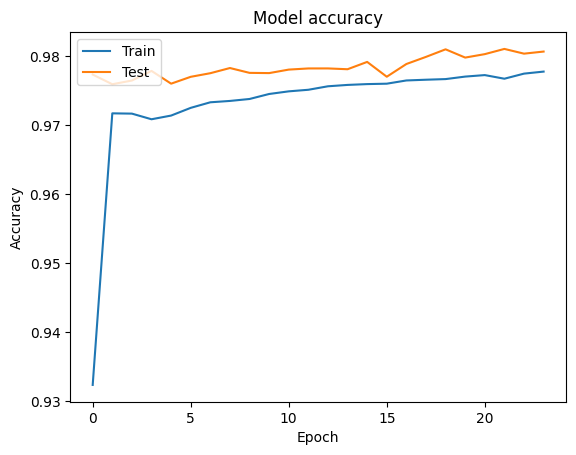

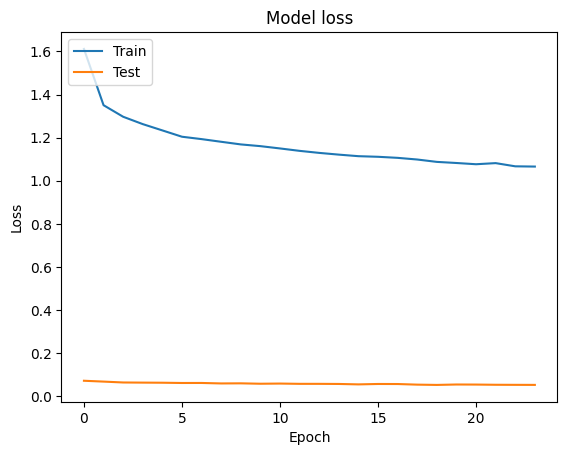

In [18]:
# Plot accuracy and loss curves
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nf-unsw-nb15-v2csv/NF-UNSW-NB15-v2.csv')  # Replace with your actual dataset path

# Show the stratified dataframe
df

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,59.166.0.5,1305,149.171.126.8,21,6,1.0,9,1,193,3,...,0,7240,0,0,0,0,0,331.0,0,Benign
1,59.166.0.5,1305,149.171.126.8,21,6,1.0,261,5,469,7,...,8688,8688,18944,74,0,0,0,230.0,0,Benign
2,59.166.0.5,1305,149.171.126.8,21,6,1.0,481,9,750,11,...,10136,10136,33792,132,0,0,0,229.0,0,Benign
3,59.166.0.5,1305,149.171.126.8,21,6,1.0,701,13,1054,15,...,11584,11584,48640,190,0,0,0,125.0,0,Benign
4,59.166.0.5,1305,149.171.126.8,21,6,1.0,1031,19,1474,21,...,14480,13032,64256,251,0,0,0,230.0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390270,59.166.0.4,58663,149.171.126.1,5190,6,0.0,1064,12,2364,14,...,10136,10136,29696,116,0,0,0,0.0,0,Benign
2390271,59.166.0.6,60977,149.171.126.4,53,17,0.0,146,2,178,2,...,0,0,0,0,19348,1,60,0.0,0,Benign
2390272,59.166.0.6,54553,149.171.126.9,80,6,7.0,994,10,8896,10,...,10136,7240,7424,29,0,0,0,0.0,0,Benign
2390273,59.166.0.6,55026,149.171.126.5,8248,6,0.0,4014,68,60268,70,...,44888,14480,8960,35,0,0,0,0.0,0,Benign


In [7]:
# Drop 'IPV4_SRC_ADDR' and 'IPV4_DST_ADDR'
df = df.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR'])

# Encode categorical columns
label_encoders = {}
categorical_columns = ['PROTOCOL', 'L7_PROTO', 'TCP_FLAGS', 'Attack']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
X = df.drop('Attack', axis=1).values
y = df['Attack'].values

In [9]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [12]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [13]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))  # 10 classes in 'Attack'

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8305 - loss: 1.5844 - val_accuracy: 0.9791 - val_loss: 0.0643
Epoch 2/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9782 - loss: 1.0659 - val_accuracy: 0.9817 - val_loss: 0.0540
Epoch 3/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9794 - loss: 0.9987 - val_accuracy: 0.9830 - val_loss: 0.0513
Epoch 4/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9807 - loss: 0.9574 - val_accuracy: 0.9834 - val_loss: 0.0504
Epoch 5/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9813 - loss: 0.9516 - val_accuracy: 0.9842 - val_loss: 0.0487
Epoch 6/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9818 - loss: 0.8975 - val_accuracy: 0.9848 - val_loss: 0.0470
Epoch 7/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9823 - loss: 0.8664 - val_accuracy: 0.9854 - val_loss: 0.0451
Epoch 8/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9826 - loss: 0

In [14]:
# Predict and evaluate
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

14940/14940 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
[[    98    349      0     11      1      1      0      0      0      0]
 [    24    383      0      1      4      6      0      4     10      2]
 [    84     13 458722     24     14    131      7      0     44      5]
 [    76    401      0    262    237     94     23     32      6     28]
 [   160    467      0    507   4188    287     67    331     77    226]
 [    36    431      0     66      6   3677      1    107     18    120]
 [    30    366      0    115    150    100   2496     19     16     20]
 [    21    361      0      8      6      9      4   2110      0     37]
 [     0      2      0      0      1      1      0      2    279      0]
 [     0      0      0      0      0      0      0      0      0     33]]
              precision    recall  f1-score   support

           0       0.19      0.21      0.20       460
           1       0.14      0.88      0.24       434
           2       1.00      1.00      1.00    459044
      

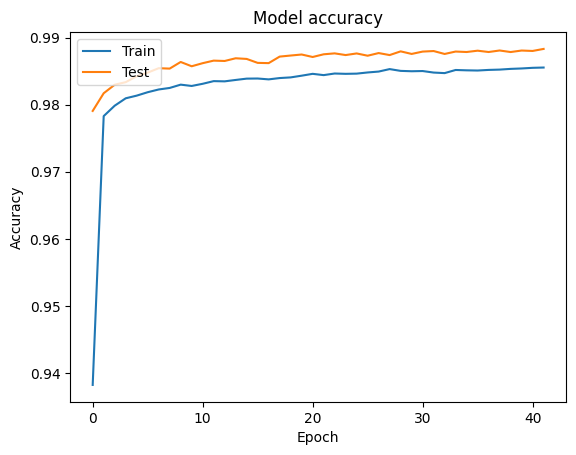

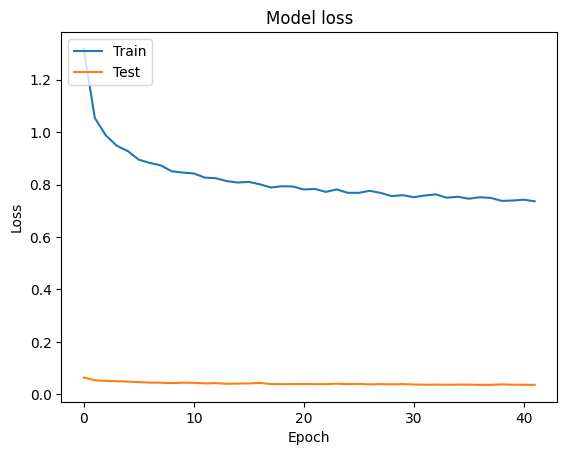

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()